In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
import diversity_tools as dt
from stargazer.stargazer import Stargazer

In [2]:
# load data
selected_cbg_brand = pd.read_csv('selected_cbg_brand.csv', index_col = 'cbg')
selected_brands = pd.read_csv('selected_brands.csv')
brand_cat = pd.read_csv('brand_cat.csv')
brand_median = pd.read_csv('brand_median.csv')
yelp_labelled = pd.read_csv('yelp_labelled.csv')
selected_cbg_stats = pd.read_csv('selected_cbg_stats.csv', index_col = 'cbg')
cbg_diversity = pd.read_csv('cbg_diversity.csv')[['cbg', 'entropy_brand', 'brand_std','entropy_price']]
cbg_availability = pd.read_csv('cbg_availability.csv')
cbg_mobility = pd.read_csv('cbg_mobility.csv')

In [3]:
selected_cbg_stats.isna().sum()

income                  0
income_moe            124
bachelor_or_higher      0
years_edu_weighted      0
median_age              0
male_proportion         0
white_proportion        0
dtype: int64

In [4]:
dt.corr_table(selected_cbg_stats)

,income,income_moe,bachelor_or_higher,years_edu_weighted,median_age,male_proportion,white_proportion
income,1.0***,0.592***,0.71***,0.681***,0.192***,0.089***,0.312***
income_moe,0.592***,1.0***,0.456***,0.4***,0.096***,0.031***,0.102***
bachelor_or_higher,0.71***,0.456***,1.0***,0.892***,0.15***,0.0,0.303***
years_edu_weighted,0.681***,0.4***,0.892***,1.0***,0.23***,0.0,0.476***
median_age,0.192***,0.096***,0.15***,0.23***,1.0***,-0.023**,0.371***
male_proportion,0.089***,0.031***,0.0,0.0,-0.023**,1.0***,0.133***
white_proportion,0.312***,0.102***,0.303***,0.476***,0.371***,0.133***,1.0***


In [5]:
# get NYC dummy variable
NYC_codes = ['36005', '36047', '36061', '36081', '36085']
cbgstrings = selected_cbg_brand.index.astype(str)
cbg_nyc = np.where(cbgstrings.str.slice(0,5).isin(NYC_codes), 1, 0)
cbg_nyc = pd.DataFrame({'cbg': cbgstrings, 'nyc_dummy': cbg_nyc}).astype({'cbg': int})

In [7]:
# merge all data
mdf = reduce(lambda left,right: pd.merge(left,right,on = 'cbg',), 
             [cbg_diversity, cbg_availability, cbg_mobility, cbg_nyc, selected_cbg_stats])

mdf = mdf.rename(columns = {'entropy_brand_x' : 'diver_brand_entropy',
                            'entropy_price_x' : 'diver_price_entropy',
                            'brand_std_x': 'diver_brand_std',
                            'brand_std_y': 'avail_brand_std',
                            'entropy_brand_y' : 'avail_brand_entropy',
                            'entropy_price_y' : 'avail_price_entropy',})
mdf = mdf.set_index('cbg')

In [8]:
mdf

,diver_brand_entropy,diver_brand_std,diver_price_entropy,avail_brand_entropy,avail_brand_std,avail_price_entropy,mobility,nyc_dummy,income,income_moe,bachelor_or_higher,years_edu_weighted,median_age,male_proportion,white_proportion
cbg,,,,,,,,,,,,,,,
360010002001,0.524237,12578.920235,0.482607,0.000000,NaN,0.000000,15.198741,0,24271.0,7620.0,0.152134,12.718924,24.8,0.454296,0.046161
360010002002,0.499989,11441.123149,0.530192,0.000000,NaN,0.000000,9.330182,0,43220.0,24803.0,0.100719,12.553957,27.4,0.169291,0.188976
360010003001,0.590318,12152.962875,0.571211,0.383831,12264.087267,0.445246,68.243987,0,48787.0,31971.0,0.488333,15.218333,36.5,0.391355,0.730140
360010003002,0.504711,11523.491242,0.482423,0.000000,NaN,0.000000,17.502456,0,37662.0,26294.0,0.075071,13.206799,23.9,0.326814,0.211356
360010003003,0.506827,11489.538437,0.558414,0.101716,6293.957459,0.500000,26.660298,0,62984.0,13672.0,0.511405,14.770419,34.8,0.517959,0.496096
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361231501005,0.457613,8925.092037,0.396989,0.203432,7352.195794,0.000000,24.575369,0,63010.0,10805.0,0.375629,13.528701,34.0,0.496394,0.989183
361231502003,0.483336,10077.160589,0.495882,0.161216,5448.674709,0.459148,24.006722,0,44107.0,13621.0,0.235499,13.226218,39.0,0.386768,0.959288
361231504004,0.464352,8675.979002,0.485063,0.161216,6280.507066,0.459148,12.396035,0,60625.0,21208.0,0.142857,13.096774,53.3,0.594025,1.000000


# all variables + income*education

In [9]:
# function to run the fixed effect model for all variables
def diversity_ols(mdf, ava_name, diver_name):
    """
    """
    df = mdf[['income', 'income_moe', 'mobility', ava_name, diver_name, 'bachelor_or_higher', 'median_age', 'male_proportion', 'white_proportion']]
    df = df.rename(columns = {ava_name: 'availability',
                              diver_name: 'diversity'})
    df = pd.DataFrame(StandardScaler().fit_transform(df), index = df.index,
                        columns = ['income', 'income_moe', 'mobility', 'availability', 'diversity', 'bachelor_or_higher', 'median_age', 'male_proportion', 'white_proportion'])
    df = df.merge(mdf['nyc_dummy'], on = 'cbg')

    formula_string = "diversity ~ availability + mobility + income_moe + income  + C(nyc_dummy) + bachelor_or_higher + median_age + male_proportion + white_proportion + income * bachelor_or_higher"

    model = sm.OLS.from_formula(formula_string, data = df).fit()
    return model

    
def regression_tables(model_lst, cols):
    # use stargazer to print
    # https://github.com/StatsReporting/stargazer

    stargazer = Stargazer(model_lst)
    stargazer.custom_columns(cols, [1]*len(cols))
    stargazer.show_model_numbers(False)
    stargazer.covariate_order(['income', 'bachelor_or_higher', 'income:bachelor_or_higher', 'income_moe', 'mobility', 'availability', 'C(nyc_dummy)[T.1]', 'median_age', 'male_proportion', 'white_proportion','Intercept'])
    rename_dic = {'income': 'Income', 
                'income_moe': 'Income variability', 
                'income:bachelor_or_higher':'income_edu_interaction',
                'mobility': 'Mobility',
                'availability': 'Local availability',
                'C(nyc_dummy)[T.1]': 'In NYC'}
    stargazer.rename_covariates(rename_dic)
    stargazer.show_degrees_of_freedom(False)
    stargazer.significance_levels([0.05, 0.01, 0.001])

    return stargazer

In [10]:
m1 = diversity_ols(mdf, 'avail_brand_entropy', 'diver_brand_entropy')
m2 = diversity_ols(mdf, 'avail_brand_std', 'diver_brand_std')
m3 = diversity_ols(mdf, 'avail_price_entropy', 'diver_price_entropy')
cols = ['Entropy by brand', "Standard deviation of brands' SES", "Entropy by brands' price level"]
model_lst = [m1, m2, m3]

In [11]:
regression_tables(model_lst, cols)

## by industry (naics 3 digits) data and function
- excluding Motion Picture and Video Industries due to limited number of observations with price and SES data
- excluding Personal and Laundry Services and Rental and Leasing Services due to limited number of brands

In [12]:
# other useful data to load
selected_brand_cat3d = pd.read_csv('selected_brand_cat3d.csv')
availability_matrix = pd.read_csv('availability_matrix.csv', index_col = 'poi_cbg')
geo_df = pd.read_csv("geo_df.csv")

# excluding the three industries
cat_n = selected_brand_cat3d.groupby('naics3_category').size()
industries = list(cat_n.index.values[cat_n > 10])

In [21]:
# using a fuction for each industry
def regression_industry(industry):
    """
    """

    brands = selected_brand_cat3d['brands'][selected_brand_cat3d['naics3_category'] == industry]

    # diversity
    diversity_matrix = selected_cbg_brand[selected_cbg_brand.columns.intersection(brands)]
    diversity = dt.get_3diversity(diversity_matrix)

    # availability
    availability_matrix_sub = availability_matrix[availability_matrix.columns.intersection(brands)]
    availability = dt.get_3diversity(availability_matrix_sub)

    # mobility
    geo_df_sub = geo_df[geo_df['brands'].isin(brands)]
    mobility = dt.get_mobility(geo_df_sub)

    # merge and clean
    mdf = reduce(lambda left,right: pd.merge(left,right,on = 'cbg',), 
                [diversity, availability, mobility, cbg_nyc, selected_cbg_stats])
    mdf = mdf.rename(columns = {'entropy_brand_x' : 'diver_brand_entropy',
                                'entropy_price_x' : 'diver_price_entropy',
                                'brand_std_x': 'diver_brand_std',
                                'brand_std_y': 'avail_brand_std',
                                'entropy_brand_y' : 'avail_brand_entropy',
                                'entropy_price_y' : 'avail_price_entropy',})
    mdf = mdf.set_index('cbg')

    # regression models
    m_entropy = diversity_ols(mdf, 'avail_brand_entropy', 'diver_brand_entropy')
    m_std = diversity_ols(mdf, 'avail_brand_std', 'diver_brand_std')
    m_price = diversity_ols(mdf, 'avail_price_entropy', 'diver_price_entropy')

    return m_entropy, m_std, m_price

In [22]:
entropy_lst = []
std_lst = []
price_lst = []

for industry in industries:
    m_entropy, m_std, m_price = regression_industry(industry)
    entropy_lst.append(m_entropy)
    std_lst.append(m_std)
    price_lst.append(m_price)

In [23]:
regression_tables(entropy_lst, industries)

In [24]:
regression_tables(std_lst, industries)

In [25]:
regression_tables(price_lst, industries)

# plot interaction effects

In [26]:
models = [m1, m2, m3]
coef_dics = []
for m in models:
    coef_dics.append(m.params.loc[['Intercept', 'income', 'bachelor_or_higher', 'income:bachelor_or_higher']].to_dict())

In [27]:
coef_dics

[{'Intercept': 0.1654732670469575,
  'income': 0.6975363764177511,
  'bachelor_or_higher': -0.14532526769179266,
  'income:bachelor_or_higher': -0.20832281545718123},
 {'Intercept': 0.2159696975629068,
  'income': 0.4031459951613413,
  'bachelor_or_higher': 0.15294193224190278,
  'income:bachelor_or_higher': -0.06631543782577198},
 {'Intercept': -0.14010016656151875,
  'income': 0.26334277954520124,
  'bachelor_or_higher': 0.217907247985725,
  'income:bachelor_or_higher': -0.06122039349348893}]

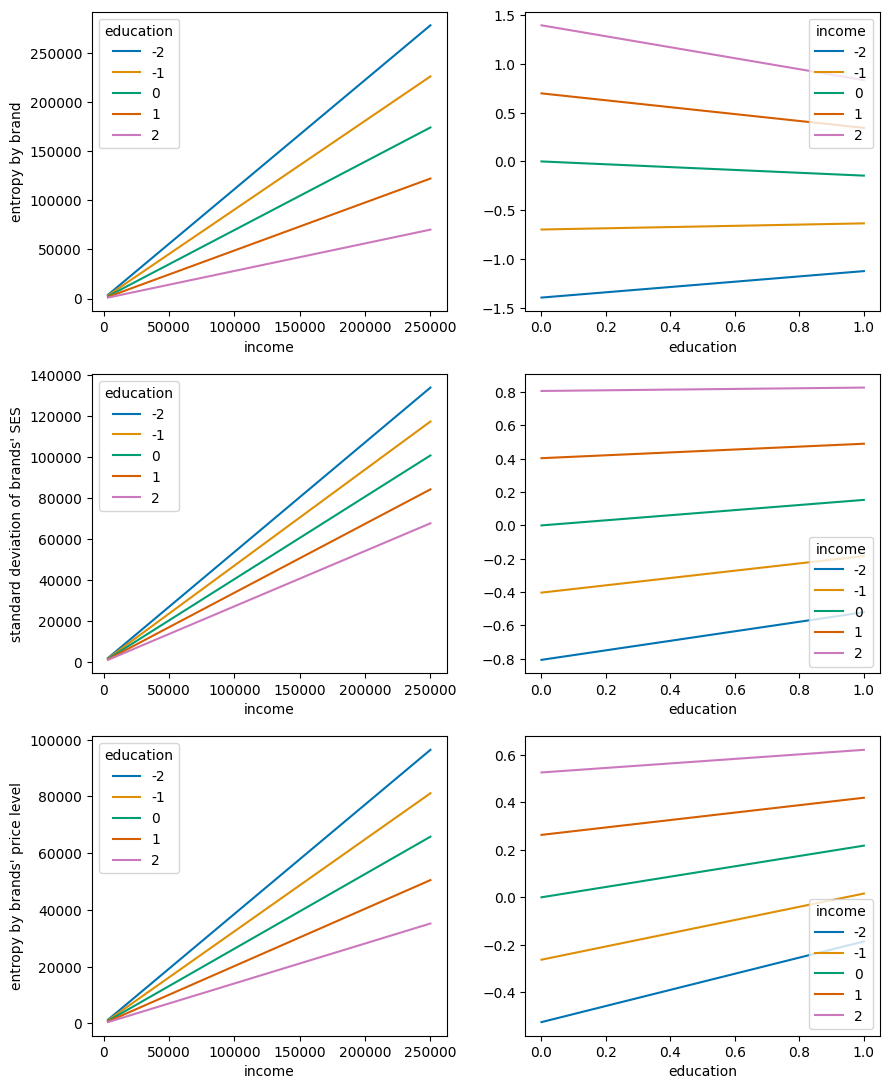

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(9, 11))  

plt.sca(axes[0, 0])  
income = mdf['income'].sort_values()
for edu in [-2, -1, 0, 1, 2]:
    y = coef_dics[0]['income'] * income + coef_dics[0]['bachelor_or_higher'] * edu + coef_dics[0]['income:bachelor_or_higher'] * income * edu
    plt.plot(income, y, label = str(edu))
plt.legend(title = 'education')
plt.xlabel('income')
plt.ylabel('entropy by brand')

plt.sca(axes[0, 1])  
edu = mdf['bachelor_or_higher'].sort_values()
for income in [-2, -1, 0, 1, 2]:
    y = coef_dics[0]['income'] * income + coef_dics[0]['bachelor_or_higher'] * edu + coef_dics[0]['income:bachelor_or_higher'] * income * edu
    plt.plot(edu, y, label=str(income))
plt.legend(title='income')
plt.xlabel('education')

plt.sca(axes[1, 0]) 
income = mdf['income'].sort_values()
for edu in [-2, -1, 0, 1, 2]:
    y = coef_dics[1]['income'] * income + coef_dics[1]['bachelor_or_higher'] * edu + coef_dics[1]['income:bachelor_or_higher'] * income * edu
    plt.plot(income, y, label = str(edu))
plt.legend(title = 'education')
plt.xlabel('income')
plt.ylabel("standard deviation of brands' SES")

plt.sca(axes[1, 1])  
edu = mdf['bachelor_or_higher'].sort_values()
for income in [-2, -1, 0, 1, 2]:
    y = coef_dics[1]['income'] * income + coef_dics[1]['bachelor_or_higher'] * edu + coef_dics[1]['income:bachelor_or_higher'] * income * edu
    plt.plot(edu, y, label=str(income))
plt.legend(title='income')
plt.xlabel('education')

plt.sca(axes[2, 0])  
income = mdf['income'].sort_values()
for edu in [-2, -1, 0, 1, 2]:
    y = coef_dics[2]['income'] * income + coef_dics[2]['bachelor_or_higher'] * edu + coef_dics[2]['income:bachelor_or_higher'] * income * edu
    plt.plot(income, y, label = str(edu))
plt.legend(title = 'education')
plt.xlabel('income')
plt.ylabel("entropy by brands' price level")

plt.sca(axes[2, 1])  
edu = mdf['bachelor_or_higher'].sort_values()
for income in [-2, -1, 0, 1, 2]:
    y = coef_dics[2]['income'] * income + coef_dics[2]['bachelor_or_higher'] * edu + coef_dics[2]['income:bachelor_or_higher'] * income * edu
    plt.plot(edu, y, label=str(income))
plt.legend(title='income')
plt.xlabel('education')

plt.tight_layout()  
plt.show()
# plt.savefig("Appendix/FigureE5.png", dpi=300)